In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 44.7MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"
#%cp "/content/drive/My Drive/automatic-asset-classification/data/final_dataset" .
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_3_torch  ae_res_5_torch       final_model  test.png
ae_res_1_torch  ae_res_4_new    ae_res_6_new         model1.pt
ae_res_2_new    ae_res_4-new    ae_res_6_torch       model2.pt
ae_res_2_torch  ae_res_4_torch  basic_animation.mp4  models/
ae_res_3_new    ae_res_5_new    data/                outputs/


In [4]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))
print("imported")

imported


In [0]:
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn
import torch
import torch.nn.functional as F
from fastai.torch_core import requires_grad, children

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts, base_loss):
        super().__init__()
        self.m_feat = m_feat
        self.base_loss = base_loss
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [self.base_loss(input,target)]
        self.feat_losses += [self.base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [self.base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

    def __del__(self): self.hooks.remove()

In [0]:
from fastai.torch_core import *
from fastai.core import ifnone
from fastai.layers import *

class reshape(nn.Module):
    '''a torch layer to reshape the input into size = shape = type list'''
    def __init__(self, shape):
        super(reshape, self).__init__()
        self.shape = shape
    def forward(self, x): return x.reshape(self.shape)

class convblock(nn.Module):
    '''
    a convolutional block used in the model:
    conv(in, out) -> batchnorm(out) -> relu
    '''
    def __init__(self, in_:int, out:int):
      super().__init__()
      self.conv1 = nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

class downsamp(nn.Module):
    ''' a downsampling block. using adaptive max pooling so select the size to be outputted and the scale you would like output ie out (3,10,10) is a downsamp(3, 10).
    '''
    def __init__(self, size:int, scale:int=2):
      super().__init__()
      self.pool = nn.AdaptiveMaxPool2d(scale)
      self.bn = nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace = True)

    def forward(self,x):
      x = self.pool(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

class Upsample(nn.Module):
    '''
    upsample by scale = scale. Ins and outs are input. Upsampling method is nearest neighbour.
    '''
    def __init__(self, in_:int, out:int, scale:int=2):
      super().__init__()
      self.upsample = nn.Upsample(scale_factor=scale, mode='nearest')
      self.bn = nn.BatchNorm2d(in_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.conv1 = nn.Sequential(
              nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
              nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.ReLU(inplace=True)
              )

    def forward(self, x):
      x = self.upsample(x)
      x = self.bn(x)
      x = self.conv1(x)
      return x

In [0]:
class encoder(nn.Module):
    def __init__(self, model_weights=True):
        super(encoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = model_weights)
        resnet = nn.Sequential(*(list(resnet.children())[0:8]))
        if model_weights:
            for param in resnet.parameters():
                param.requires_grad = False
        else:
            for param in resnet.parameters():
                param.requires_grad = True


        self.encoder = nn.Sequential(resnet, AdaptiveConcatPool2d(), nn.Flatten())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()

        self.bottleneck = nn.Sequential(nn.Linear(1024, 24 * 8 * 8),
                                        reshape([-1,24,8,8])
                                        )

        self.up1 = Upsample(24,12,scale=7)
        self.up2 = Upsample(12,6,scale=2)
        self.up3 = Upsample(6,3)

    def forward(self,x):
        x = self.bottleneck(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        return x

class autoencoder(nn.Module):
    def __init__(self, model_weights=True):
        super(autoencoder, self).__init__()

        self.encoder = encoder(model_weights)
        self.decoder = decoder()

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clamp(x, min = 0, max = 1)


In [27]:
AE1=autoencoder()
AE2=autoencoder()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [9]:
vgg_m = vgg16_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

base_loss = F.mse_loss

feat_loss = FeatureLoss(vgg_m, blocks[0:3], [30,20,10], base_loss)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
learn1 = Learner(data, AE1, loss_func=F.mse_loss)
learn2 = Learner(data, AE2, loss_func=feat_loss)

In [29]:
learn1.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.180319,0.167272,01:14
1,0.140648,0.107657,00:24
2,0.122013,0.090838,00:23
3,0.111622,0.086233,00:24
4,0.105184,0.085619,00:24


In [30]:
learn1.lr_find()

epoch,train_loss,valid_loss,time
0,0.090473,#na#,00:17
1,0.089391,#na#,00:18
2,0.089265,#na#,00:18
3,0.090129,#na#,00:18
4,0.089021,#na#,00:17
5,0.085816,#na#,00:18
6,0.082614,#na#,00:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-01
Min loss divided by 10: 1.10E-01


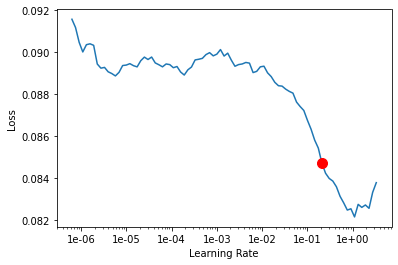

In [31]:
learn1.recorder.plot(suggestion=True)

In [37]:
learn1.split(lambda m: (m.encoder.encoder[0][1], m.encoder.encoder[0][2], m.encoder.encoder[0][3], m.encoder.encoder[0][4], m.encoder.encoder[0][5], 
                       m.encoder.encoder[0][6], m.encoder.encoder[0][7], m.encoder.encoder[1], m.decoder))

Learner(data=ImageDataBunch;

Train: LabelList (444 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: data/final_dataset;

Valid: LabelList (110 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: data/final_dataset;

Test: None, model=autoencoder(
  (encoder): encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mo

In [38]:
learn1.unfreeze()
learn1.fit_one_cycle(10, max_lr=slice(1e-05, 1e-01))

epoch,train_loss,valid_loss,time
0,0.087092,0.248412,00:23
1,0.073714,0.254504,00:21
2,0.065649,0.276522,00:23
3,0.061285,0.055437,00:22
4,0.056683,0.073729,00:22
5,0.055709,0.130868,00:22
6,0.052828,0.053529,00:22
7,0.050244,0.040439,00:21
8,0.047954,0.038484,00:21
9,0.046223,0.037507,00:22


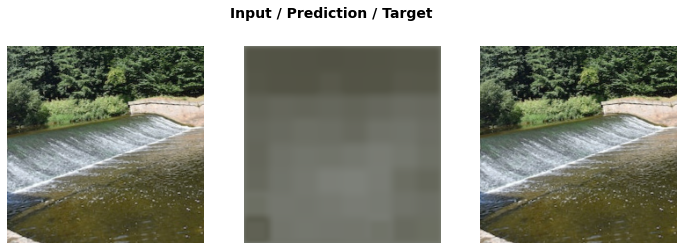

In [39]:
learn1.show_results(ds_type=DatasetType.Train, rows=1)

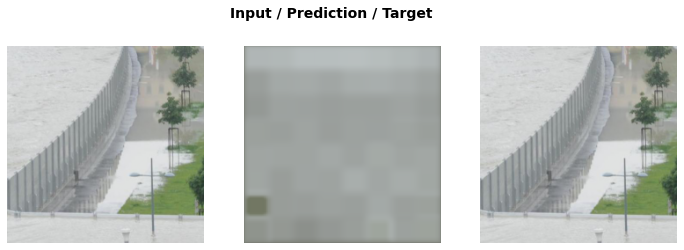

In [40]:
learn1.show_results(ds_type=DatasetType.Valid, rows=1)

In [0]:
learn2.metrics = [mean_squared_error]

In [42]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,mean_squared_error,time
0,1.525502,1.174613,0.263390,00:24
1,1.207358,0.899832,0.261796,00:24
2,1.051890,0.821907,0.260666,00:25
3,0.971499,0.802514,0.249559,00:23
4,0.923754,0.796674,0.248174,00:23


In [43]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01
Min loss divided by 10: 7.59E-02


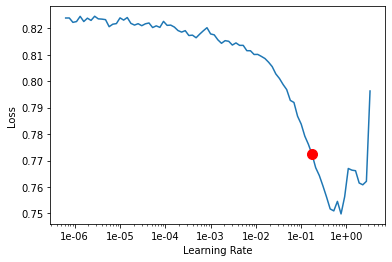

In [44]:
learn2.recorder.plot(suggestion=True)

In [45]:
learn2.split(lambda m: (m.encoder.encoder[0][1], m.encoder.encoder[0][2], m.encoder.encoder[0][3], m.encoder.encoder[0][4], m.encoder.encoder[0][5], 
                       m.encoder.encoder[0][6], m.encoder.encoder[0][7], m.encoder.encoder[1], m.decoder))
print("split")

split


In [46]:
learn2.unfreeze()
learn2.fit_one_cycle(10, max_lr=slice(1e-05, 1e-01))

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.740021,0.753857,0.214249,00:25
1,0.636919,0.756237,0.270632,00:25
2,0.595474,0.778814,0.249940,00:25
3,0.568562,0.785833,0.231087,00:25
4,0.550256,0.496962,0.061543,00:26
5,0.537223,0.521714,0.073162,00:26
6,0.528340,0.493301,0.062799,00:26
7,0.522979,0.488843,0.060901,00:25
8,0.516405,0.487411,0.060218,00:25
9,0.512161,0.487744,0.060945,00:24


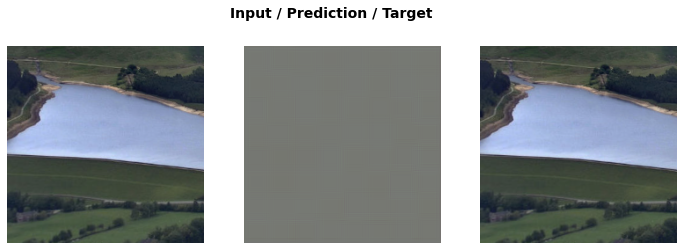

In [47]:
learn2.show_results(ds_type=DatasetType.Train, rows=1)

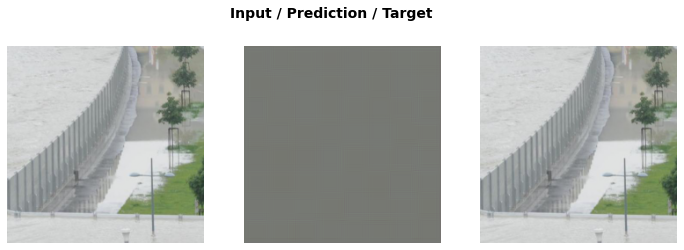

In [48]:
learn2.show_results(ds_type=DatasetType.Valid, rows=1)

In [49]:
torch.save(learn1.model, "res_model1.pt")
torch.save(learn2.model, "res_model2.pt")
%cp "res_model1.pt" "/content/drive/My Drive/automatic-asset-classification/models/res_model1.pt" 
%cp "res_model2.pt" "/content/drive/My Drive/automatic-asset-classification/models/res_model2.pt"

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6

In [0]:
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.encoder = torch.load("res_model1.pt").encoder
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

class Encoder2(nn.Module):

    def __init__(self):
        super(Encoder2, self).__init__()  
        self.encoder = torch.load("res_model2.pt").encoder
        
    def encode(self,x): return self.encoder(x)        

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [0]:
ec1,ec2 = Encoder1(), Encoder2()
enc1=Learner(data, ec1,loss_func=F.mse_loss)
enc2=Learner(data, ec2,loss_func=F.mse_loss)

In [54]:
preds_1,acts_1=enc1.get_preds()
preds_2,acts_2=enc2.get_preds()

In [0]:
cluster_data_1 = preds_1.numpy()
cluster_data_2 = preds_2.numpy()

In [0]:
cluster_data_std_1 = (cluster_data_1 - cluster_data_1.mean())/cluster_data_1.std()
cluster_data_std_2 = (cluster_data_2 - cluster_data_2.mean())/cluster_data_2.std()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cluster_data_pca_1 = pca.fit_transform(cluster_data_std_1)
pca = PCA(n_components=50)
cluster_data_pca_2 = pca.fit_transform(cluster_data_std_2)

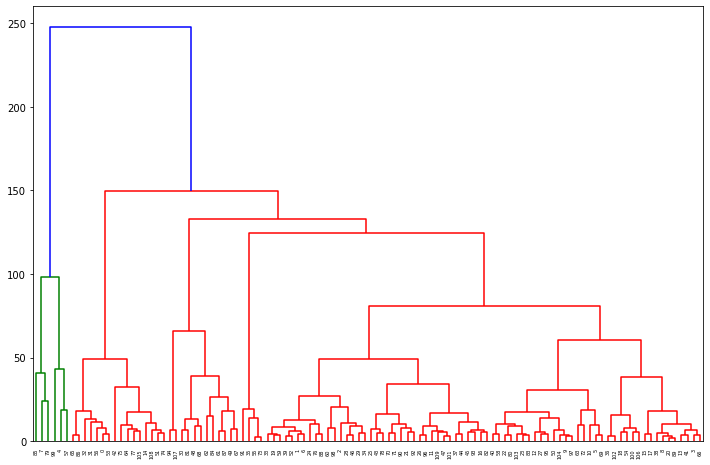

In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(cluster_data_pca_1, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

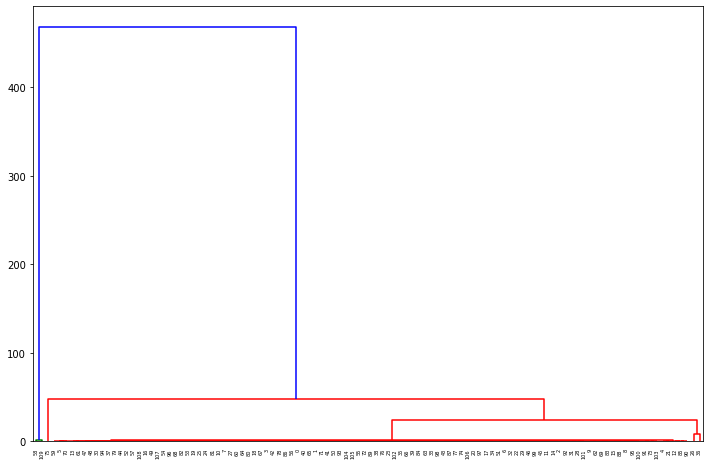

In [59]:
linked = linkage(cluster_data_pca_2, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [0]:
from sklearn.manifold import TSNE
X1_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca_1)
X1_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca_1)
X1_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca_1)

X2_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca_2)
X2_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca_2)
X2_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca_2)

In [0]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clusters_1 = cluster.fit_predict(cluster_data_pca_1)

In [0]:
cluster_2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clusters_2 = cluster_2.fit_predict(cluster_data_pca_2)

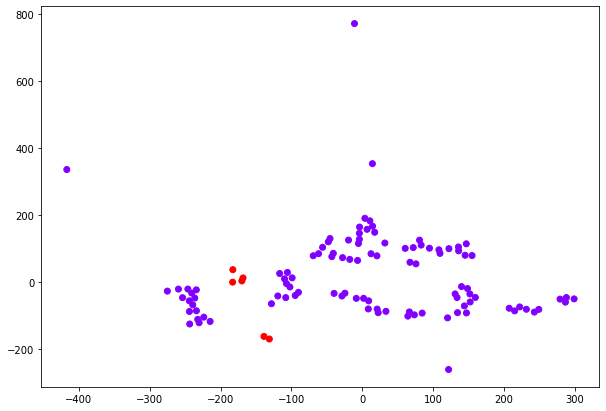

In [69]:
plt.figure(figsize=(10, 7))
plt.scatter(X1_embedded[:,0], X1_embedded[:,1], c=cluster.labels_, cmap='rainbow')

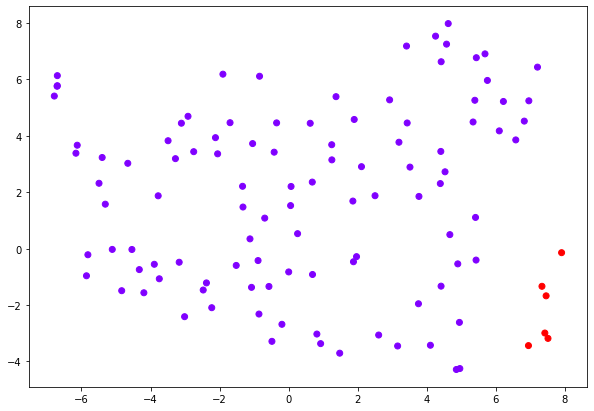

In [70]:
plt.figure(figsize=(10, 7))
plt.scatter(X1_embedded2[:,0], X1_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

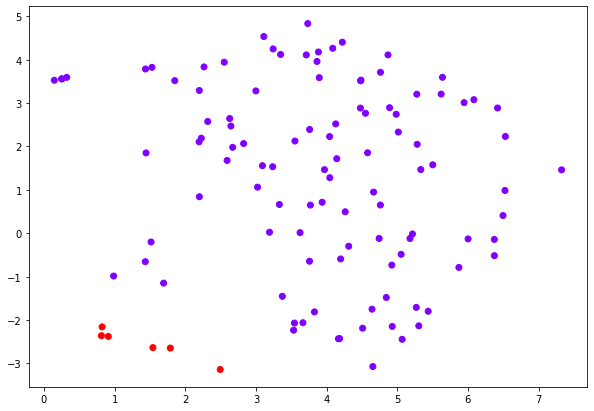

In [71]:
plt.figure(figsize=(10, 7))
plt.scatter(X1_embedded3[:,0], X1_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

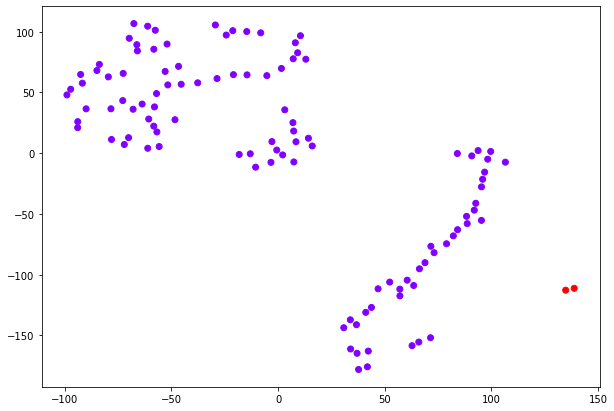

In [72]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded[:,0], X2_embedded[:,1], c=cluster_2.labels_, cmap='rainbow')

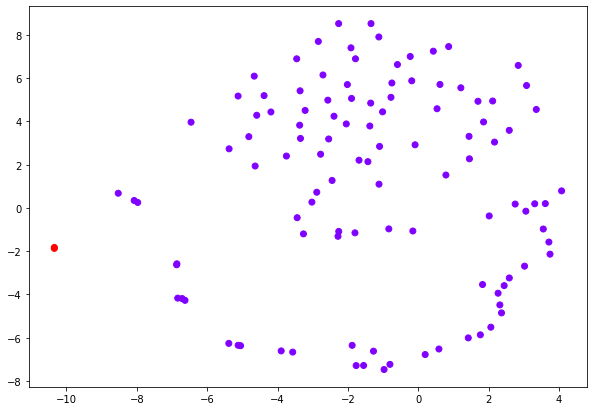

In [73]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded2[:,0], X2_embedded2[:,1], c=cluster_2.labels_, cmap='rainbow')

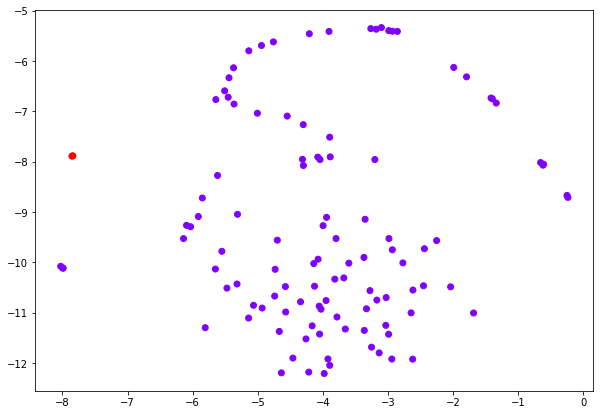

In [74]:
plt.figure(figsize=(10, 7))
plt.scatter(X2_embedded3[:,0], X2_embedded3[:,1], c=cluster_2.labels_, cmap='rainbow')

In [0]:
one_idx = []
two_idx = []

for i in range(len(clusters_1)):
  if clusters_1[i] == 0:
    one_idx.append(i)
  if clusters_1[i] == 1:
    two_idx.append(i)

In [0]:
for idx in one_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder/class1/"+str(idx)+".png")
for idx in two_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_autoencoder/class2/"+str(idx)+".png")

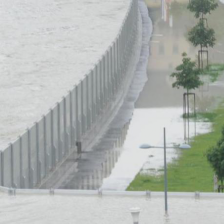

In [85]:
data.valid_ds[0][0]

In [99]:
data.valid_ds[0][0].data.numpy()

array([[[0.847059, 0.849982, 0.843155, 0.847046, ..., 0.762126, 0.788218, 0.770632, 0.777451],
        [0.842148, 0.843124, 0.848044, 0.846034, ..., 0.682509, 0.742702, 0.765541, 0.789167],
        [0.838226, 0.831377, 0.850035, 0.84501 , ..., 0.582956, 0.652301, 0.716215, 0.761492],
        [0.836354, 0.824712, 0.854915, 0.843097, ..., 0.568682, 0.596635, 0.631642, 0.673719],
        ...,
        [0.828392, 0.833355, 0.834389, 0.831504, ..., 0.803948, 0.803922, 0.80976 , 0.807791],
        [0.827486, 0.825525, 0.815712, 0.805953, ..., 0.803948, 0.803922, 0.810771, 0.808832],
        [0.805944, 0.804954, 0.800022, 0.795102, ..., 0.803974, 0.799059, 0.801978, 0.800998],
        [0.794118, 0.793128, 0.789207, 0.788249, ..., 0.804001, 0.794153, 0.793133, 0.794118]],

       [[0.85098 , 0.853904, 0.847076, 0.850967, ..., 0.785656, 0.810776, 0.790244, 0.797059],
        [0.84607 , 0.847046, 0.851965, 0.849956, ..., 0.702099, 0.762293, 0.783184, 0.806806],
        [0.842148, 0.835299, 0.8539

In [103]:
data.valid_ds[0][0].data.numpy().reshape(224,224,3).shape

(224, 224, 3)

In [104]:
data.valid_ds[0][0].data.shape

torch.Size([3, 224, 224])

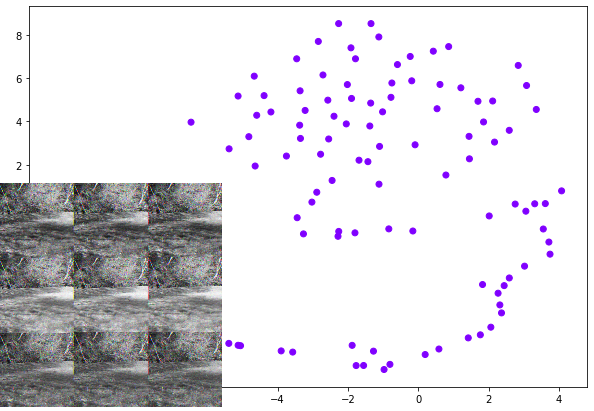

In [120]:
plt.figure(figsize=(10, 7))
ax=plt.scatter(X2_embedded2[:,0], X2_embedded2[:,1], c=cluster_2.labels_, cmap='rainbow')

ax.figure.figimage(data.valid_ds[1][0].data.numpy().reshape(224,224,3),X2_embedded2[1,0],X2_embedded2[1,1])


In [117]:
X2_embedded2[0]

array([-0.776828,  5.109066], dtype=float32)